# # Sparse Mean-Reverting Portfolio (SMRP) Strategy
This notebook implements a statistical arbitrage strategy that identifies and trades mean-reverting portfolios in the financial markets. The strategy:
1. Finds optimal pairs of assets that exhibit mean-reversion properties
2. Builds diversified portfolios starting from these pairs
3. Tests the portfolios for profitability and stationarity
4. Selects the best performing portfolios for trading
5. Simulates trading with Bollinger Bands and calculates performance metrics

# ## 1. Load and Prepare Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import random
import time
import os
from pathlib import Path

# Import custom modules
from sdp_optimizers import optimize_predictability, optimize_portmanteau, optimize_crossing
from portfolio_metrics import compute_autocovariance, calculate_predictability_score, calculate_portmanteau_score, calculate_crossing_score, truncate_portfolio
from pair_finders import find_best_pairs_sdp_exhaustive, get_optimal_pairs
from portfolio_builders import build_portfolio_min_eigenvalue, generate_diverse_portfolios
from trading_strategy import StatisticalArbitrageStrategy, run_diverse_portfolio_analysis, combine_test_results

# Configure matplotlib for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 12

file_path = "/Users/devanshjoshi/Desktop/QuantCode/StatArb/SMRP-SDP-SPCA/Daily_India.csv"   # Update with your file path

# Check if file exists
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Could not find data file at {file_path}. Please update the path.")

# Load data
print(f"Loading data from {file_path}...")
df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

# Display summary information
print(f"Data loaded successfully!")

# 
# Now we'll define the tickers we want to include in our analysis. We can use predefined groups or select from all available tickers.
custom_tickers = ["AXISBANK.NS", "BAJAJFINSV.NS", "BAJFINANCE.NS", "HDFCBANK.NS", "ICICIBANK.NS", 
                 "KOTAKBANK.NS", "SBIN.NS", "BANKBARODA.NS", "PNB.NS", "ITC.NS", "BRITANNIA.NS", 
                 "HINDUNILVR.NS", "DABUR.NS", "APOLLOHOSP.NS", "CIPLA.NS", "DRREDDY.NS", "SUNPHARMA.NS",
                 "BAJAJ-AUTO.NS", "HEROMOTOCO.NS", "TVSMOTOR.NS", "TITAN.NS", "TRENT.NS",
                 "AMBUJACEM.NS", "ULTRACEMCO.NS", "VEDL.NS", "TATASTEEL.NS", "GRASIM.NS", "UPL.NS"]

selected_tickers = custom_tickers  # Option 3

# Validate selected tickers against the data
valid_tickers = [ticker for ticker in selected_tickers if ticker in df.columns]
print(f"Using {len(valid_tickers)} valid tickers out of {len(selected_tickers)}")

# Filter data to include only valid tickers
df = df[valid_tickers]

def set_random_dates():
    # Find the min and max dates in the dataset
    min_date = df.index.min()
    max_date = df.index.max()
    
    # Calculate the available range in days
    available_range = (max_date - min_date).days
    
    # Make sure we have enough data (at least 2 years)
    if available_range < 730:  # 2 years * 365 days
        raise ValueError("Not enough data for analysis - need at least 2 years")
    
    # Set a random start date, ensuring at least 1.5 years of data after it
    max_start = max_date - pd.Timedelta(days=365*2)
    
    # Generate random date between min_date and max_start
    days_range = (max_start - min_date).days
    random_days = random.randint(0, days_range)
    random_start = min_date + pd.Timedelta(days=random_days)
    
    # End date is 1.5 years after start date
    random_end = random_start + pd.Timedelta(days=365*1.5)
    
    return random_start.strftime('%Y-%m-%d'), random_end.strftime('%Y-%m-%d')

start_date, end_date = set_random_dates()

print(f"Analysis period: {start_date} to {end_date}")

Loading data from /Users/devanshjoshi/Desktop/QuantCode/StatArb/SMRP-SDP-SPCA/Daily_India.csv...
Data loaded successfully!
Using 28 valid tickers out of 28
Analysis period: 2015-01-04 to 2016-07-04


# ## 2. Set Strategy Parameters

In [2]:

# Strategy parameters
params = {
    # Portfolio generation
    'num_portfolios': 30,        # Number of portfolios to generate
    'portfolio_size': 5,         # Target size of each portfolio
    'max_lag': 10,               # Maximum lag for autocorrelation analysis
    'crossing_mu': 0.1,          # Weight for higher-order terms in crossing criterion
    'randomize_factor': 0.7,     # Factor determining the randomness of portfolio selection
    
    # Trading strategy
    'lookback': 15,              # Window for moving average calculation
    'std_dev': 1.5,              # Number of standard deviations for Bollinger Bands
    'adf_threshold': 0.25,       # Significance level for ADF test
    'stop_loss_pct': -0.01,      # Stop loss threshold as percentage
    'take_profit_pct': 0.03,     # Take profit threshold as percentage
    
    # Results selection
    'top_n': 2,                  # Number of top portfolios to select
}

# Print parameters for reference
print("Strategy Parameters:")
for key, value in params.items():
    print(f"  {key}: {value}")


Strategy Parameters:
  num_portfolios: 30
  portfolio_size: 5
  max_lag: 10
  crossing_mu: 0.1
  randomize_factor: 0.7
  lookback: 15
  std_dev: 1.5
  adf_threshold: 0.25
  stop_loss_pct: -0.01
  take_profit_pct: 0.03
  top_n: 2


# ## 3. Run Diverse Portfolio Analysis

Period breakdown:
- Reference period: 2015-01-04 to 2015-03-05
- Training period: 2015-03-05 to 2015-11-03
- Validation period: 2015-11-03 to 2016-03-03
- Test period: 2016-03-03 to 2016-07-04
Median variance: 0.000499
Volatility threshold: 0.000050

Generating 30 diverse portfolios...
Finding optimal pairs for each criterion using SDP and sPCA...

Optimizing for Predictability:
Predictability pair: ['HDFCBANK.NS', 'KOTAKBANK.NS']
Weights: [0.9164, -0.0836]
Score: 0.004520

Optimizing for Portmanteau:
Portmanteau pair: ['HDFCBANK.NS', 'GRASIM.NS']
Weights: [0.6413, -0.3587]
Score: 0.150715

Optimizing for Crossing:
Crossing pair: ['BANKBARODA.NS', 'TATASTEEL.NS']
Weights: [0.9780, 0.0220]
Score: -0.006304

Testing portfolio 1...
Return check pass? False
ADF pass? False

Testing portfolio 2...
Return check pass? False
ADF pass? False

Testing portfolio 3...
Return check pass? False
ADF pass? False

Testing portfolio 4...
Return check pass? True
ADF pass? False

Testing portfolio 5...
Re

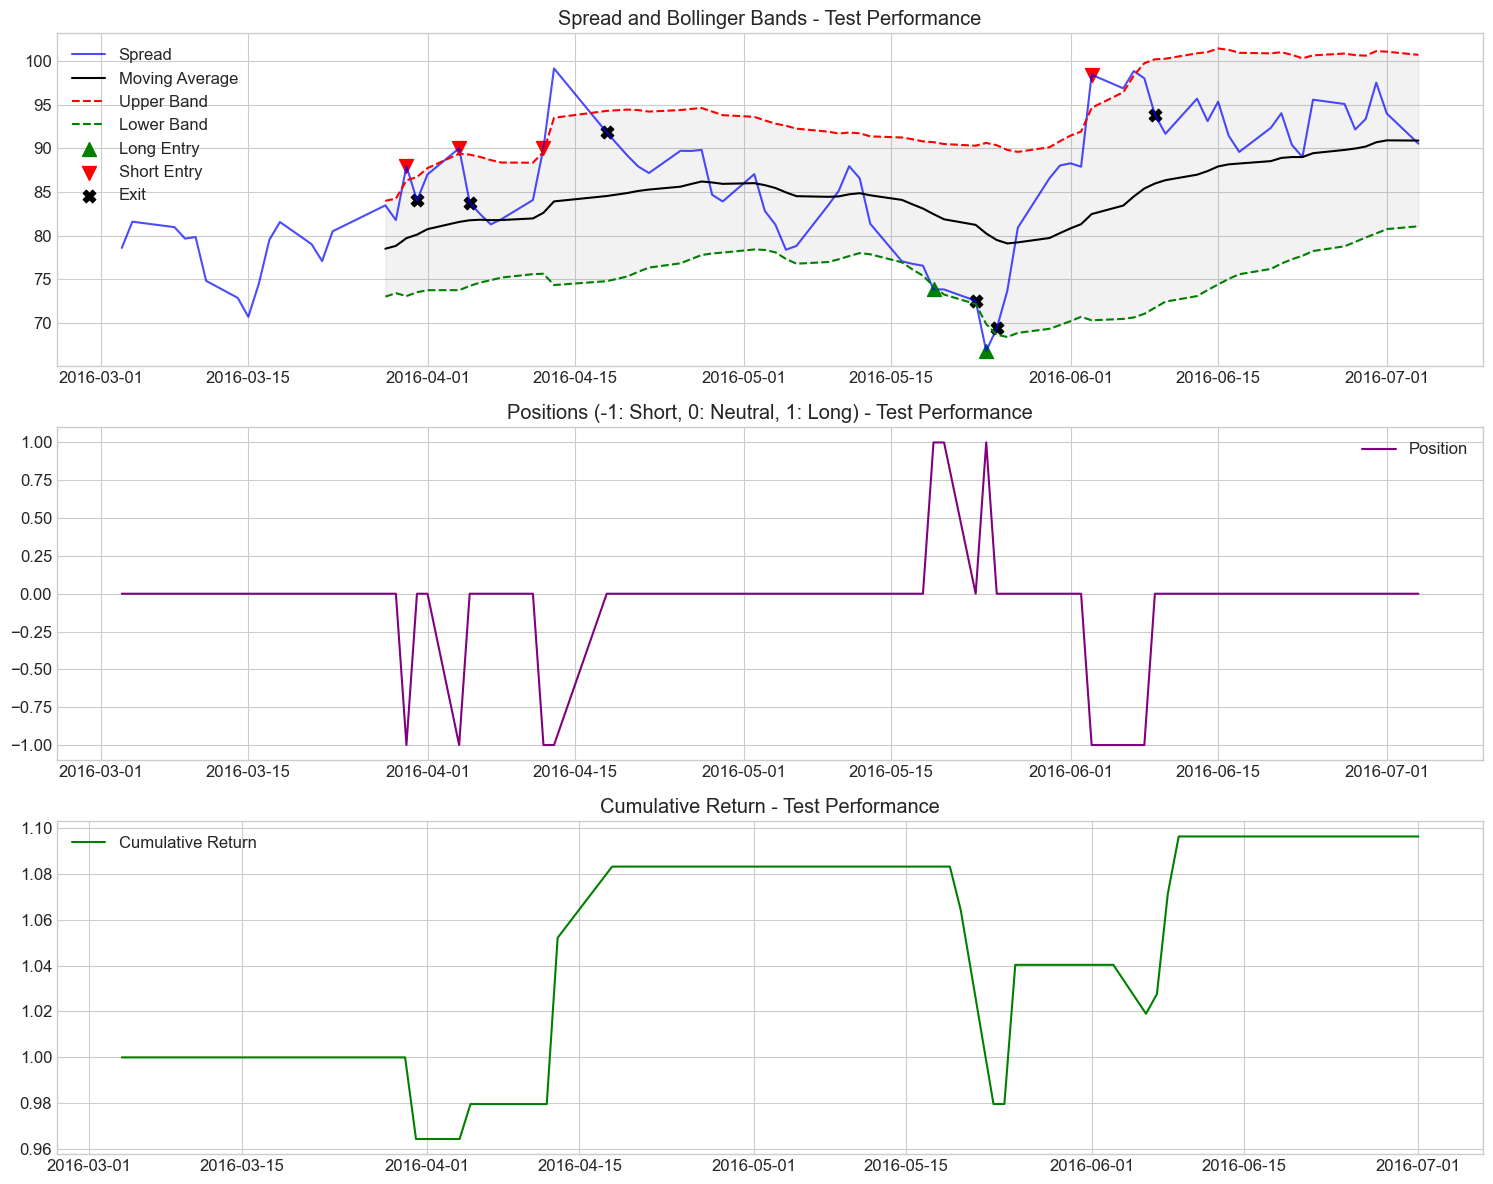


Analysis completed in 2.17 seconds (0.04 minutes)

Final Combined Test Performance:
Total Return: 0.0962
Annualized Return: 0.3262
Annualized Volatility: 0.2555
Sharpe Ratio: 1.1008
Maximum Drawdown: -0.0955
Hit Rate: 0.6364


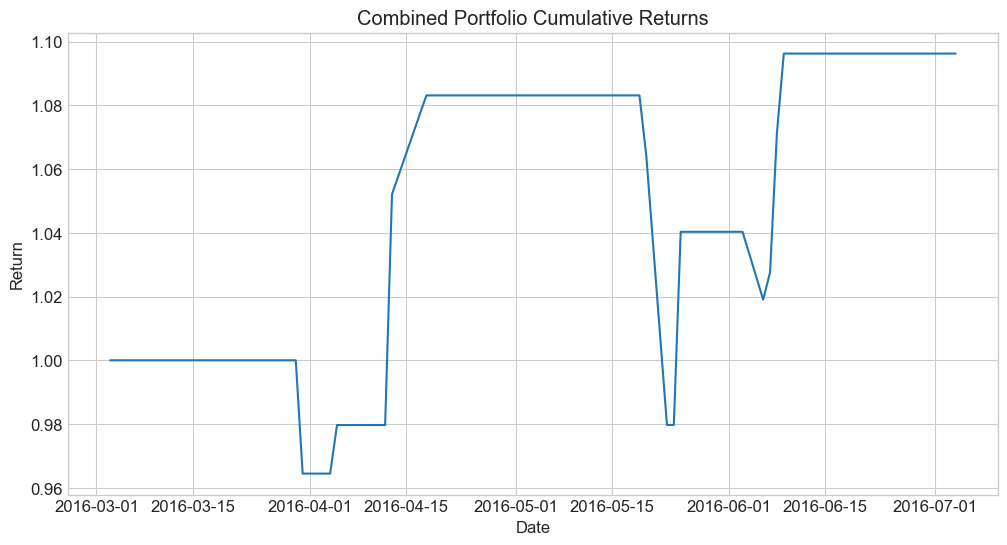

In [3]:
start_time = time.time()

# Run the analysis
results = run_diverse_portfolio_analysis(
    df,
    start_date=start_date,
    end_date=end_date,
    tickers=valid_tickers,
    **params
)

# Calculate execution time
execution_time = time.time() - start_time
print(f"\nAnalysis completed in {execution_time:.2f} seconds ({execution_time/60:.2f} minutes)")

# Print final results
if results and results.get('combined_test_results'):
    print("\nFinal Combined Test Performance:")
    metrics = results['combined_test_results']['metrics']
    print(f"Total Return: {metrics['total_return']:.4f}")
    print(f"Annualized Return: {metrics['annualized_return']:.4f}")
    print(f"Annualized Volatility: {metrics['annualized_volatility']:.4f}")
    print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.4f}")
    print(f"Maximum Drawdown: {metrics['max_drawdown']:.4f}")
    print(f"Hit Rate: {metrics['win_rate']:.4f}")
    
    # Plot combined performance
    plt.figure(figsize=(12, 6))
    cumulative_returns = (1+results['combined_test_results']['signals']['pnl']).cumprod()
    plt.plot(cumulative_returns)
    plt.title("Combined Portfolio Cumulative Returns")
    plt.xlabel("Date")
    plt.ylabel("Return")
    plt.grid(True)
    plt.show()
else:
    print("\nNo portfolios passed checks. No test results available.")
